# Analysis

## Utilities functions

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def convertJSONToPandas(path):
    """
    Convert the nested JSON results file into a flat pandas DataFrame.
    
    The JSON structure is: {epsilon: {model: {clean_acc, robust_acc, rank}}}
    This function flattens it to rows with columns: epsilon, model, clean_acc, robust_acc, rank
    
    Args:
        path: Path object pointing to the JSON results file
        
    Returns:
        pd.DataFrame: Flattened results with one row per (epsilon, model) combination,
                      or None if the file doesn't exist
    """
    if path.exists():
        # Load the JSON results file
        with path.open("r") as f:
            results = json.load(f)
        
        # Flatten nested structure into list of row dictionaries
        rows = []
        for eps, models in results.items():           # Outer loop: epsilon values
            for model, metrics in models.items():      # Inner loop: models
                rows.append({
                    "epsilon": eps,                    # Perturbation budget (e.g., "8/255")
                    "model": model,                    # Model name from RobustBench
                    **metrics                          # Unpack metrics: clean_acc, robust_acc, rank
	            })
        return pd.DataFrame(rows)
    return None

In [3]:
path = Path("../json/results_checkpoint.json")
df = convertJSONToPandas(path)

## Plots

### 1. Robust Accuracy vs. Epsilon (ε)

In [4]:
def plot_RobustAccVsEpsilon(df):
    """
    Plot robust accuracy vs. epsilon for all models.
    
    This visualization shows how each model's adversarial robustness degrades
    as the attack budget (epsilon) increases. Models with flatter curves are
    more stable across different perturbation budgets.
    
    Args:
        df: DataFrame with columns 'model', 'epsilon', 'robust_acc'
    """
    plt.figure(figsize=(7.5, 4.5))

    # Plot one line per model, grouped by model name
    for model_name, model_results in df.groupby("model"):
        plt.plot(
            model_results["epsilon"],      # X-axis: epsilon values
            model_results["robust_acc"],   # Y-axis: robust accuracy
            marker="o",                    # Circle markers at data points
            linewidth=2,
            label=model_name
        )

    plt.xlabel("Epsilon (ε)")
    plt.ylabel("Robust Accuracy")
    plt.title("Robust accuracy vs. Epsilon (ε)")
    plt.ylim(0.0, 1.0)    # Accuracy range: 0% to 100%
    plt.grid(alpha=0.3)   # Light grid for readability
    plt.legend(fontsize=8)
    plt.show()

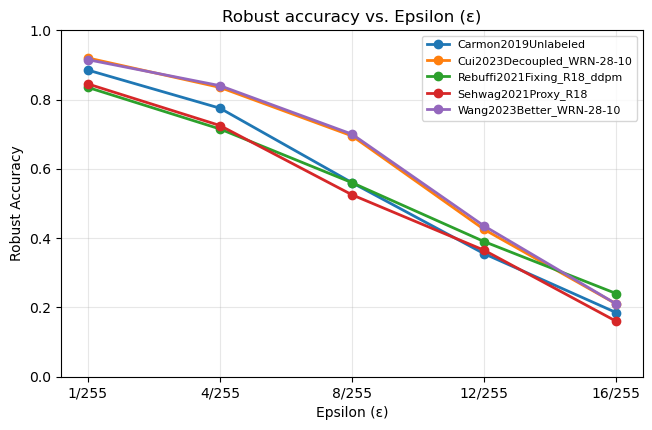

In [5]:
plot_RobustAccVsEpsilon(df)

### 2. Clean-Robust Accuracy drop

In [6]:
def plot_CleanRobustAccuracyDrop(df):
    """
    Plot the accuracy drop (clean - robust) vs. epsilon as line chart.
    
    This shows how much accuracy each model loses under adversarial attack.
    Higher values indicate the model is more vulnerable to adversarial perturbations.
    The drop increases with epsilon since larger perturbations are harder to defend.
    
    Args:
        df: DataFrame with columns 'model', 'epsilon', 'clean_acc', 'robust_acc'
    """
    plt.figure(figsize=(7.5, 4.5))

    # Plot one line per model
    for model_name, model_results in df.groupby("model"):
        # Calculate accuracy drop: how much worse the model performs under attack
        drop = model_results["clean_acc"] - model_results["robust_acc"]
        plt.plot(
            model_results["epsilon"],
            drop,
            marker="o",
            linewidth=2,
            label=model_name
        )

    plt.xlabel("Epsilon (ε)")
    plt.ylabel("Clean−Robust Accuracy")  # Accuracy drop (higher = more vulnerable)
    plt.title("Clean-Robust Accuracy drop")
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)
    plt.show()

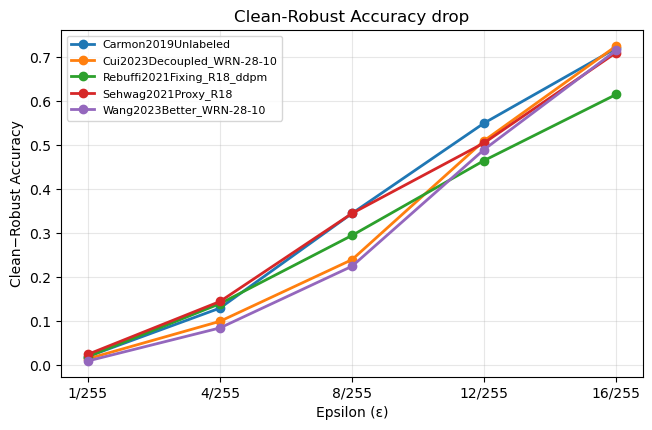

In [7]:
plot_CleanRobustAccuracyDrop(df)

In [8]:
def plot_CleanAccuracyDropHistogram(df):
    """
    Plot a grouped bar chart showing accuracy drops for each model across epsilons.
    
    This visualization allows direct comparison of accuracy drops between models
    at each epsilon value. Each epsilon has a cluster of bars (one per model),
    making it easy to see which models are most/least affected at each perturbation level.
    
    Args:
        df: DataFrame with columns 'model', 'epsilon', 'clean_acc', 'robust_acc'
    """
    
    def eps_to_float(eps_str):
        """Convert epsilon string fraction (e.g., '8/255') to float for sorting."""
        num, denom = eps_str.split("/")
        return int(num) / int(denom)
    
    # Get sorted list of epsilon values and all model names
    epsilons = sorted(df["epsilon"].unique().tolist(), key=eps_to_float)
    models = df["model"].unique().tolist()

    # Create x-axis positions for bar groups
    x = np.arange(len(epsilons))           # Base positions for each epsilon
    width = 0.8 / len(models)               # Width of each bar (divided to fit all models)

    plt.figure(figsize=(7.5, 4.5))
    
    # Plot bars for each model
    for i, model in enumerate(models):
        model_df = df[df["model"] == model]
        clean_acc = model_df["clean_acc"].iloc[0]  # Clean accuracy is constant across epsilons
        
        # Calculate accuracy drop for each epsilon
        drops = [
            clean_acc - model_df[model_df["epsilon"] == eps]["robust_acc"].iloc[0]
            for eps in epsilons
        ]
        # Offset each model's bars to create grouped effect
        plt.bar(x + i * width, drops, width=width, label=model)

    # Center x-tick labels under each group of bars
    plt.xticks(x + width * (len(models) - 1) / 2, epsilons)
    plt.xlabel("Epsilon (ε)")
    plt.ylabel("Accuracy drop (clean − robust)")
    plt.title("Clean-Robust Accuracy drop")
    plt.legend(fontsize=8)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

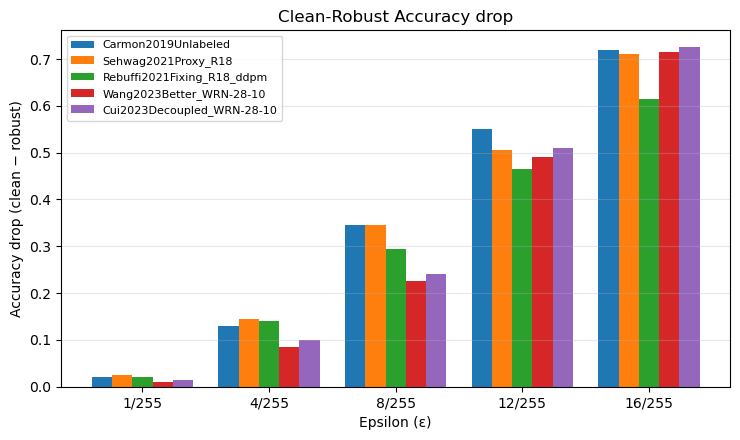

In [9]:
plot_CleanAccuracyDropHistogram(df)

### 3. Ranking across Epsilons (ε)

In [10]:
def plot_RankingAcrossEpsilons(df):
    """
    Plot model rankings across different epsilon values.
    
    This visualization is key for analyzing the stability of RobustBench leaderboards.
    If rankings change significantly across epsilon values, it suggests that the
    benchmark's default epsilon (8/255) may not tell the complete robustness story.
    
    The plot includes epsilon=0 (clean accuracy ranking) if available from a
    separate clean_ranking.json file.
    
    Args:
        df: DataFrame with columns 'model', 'epsilon', 'rank'
    """
    plt.figure(figsize=(7.5, 4.5))
    
    # Load clean ranking data (epsilon = 0) from separate file if available
    # This represents rankings based on clean accuracy (no attack)
    clean_ranking_path = Path("../json/clean_ranking.json")
    clean_ranks = {}
    if clean_ranking_path.exists():
        with clean_ranking_path.open("r") as f:
            clean_data = json.load(f)
        # Extract ranks from the clean ranking data
        for eps_key, models in clean_data.items():
            for model, metrics in models.items():
                clean_ranks[model] = metrics["rank"]

    # Plot ranking trajectory for each model
    for model_name, model_results in df.groupby("model"):
        # Build epsilon list starting with 0 (clean) then adversarial epsilons
        epsilons = ["0"] + model_results["epsilon"].tolist()
        ranks = []
        
        # Add clean rank (epsilon = 0) if available, otherwise NaN
        if model_name in clean_ranks:
            ranks.append(clean_ranks[model_name])
        else:
            ranks.append(np.nan)
        
        # Add adversarial ranks for each epsilon
        ranks.extend(model_results["rank"].tolist())
        
        plt.plot(epsilons, ranks, marker="o", linewidth=2, label=model_name)

    plt.xlabel("Epsilon (ε)")
    plt.ylabel("Ranking")
    plt.title("Ranking across Epsilons (ε)")
    plt.gca().invert_yaxis()    # Invert Y-axis so rank 1 (best) is at top
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Integer ticks only
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8, bbox_to_anchor=(1.02, 1), loc='upper left')  # Legend outside plot
    plt.tight_layout()
    plt.show()

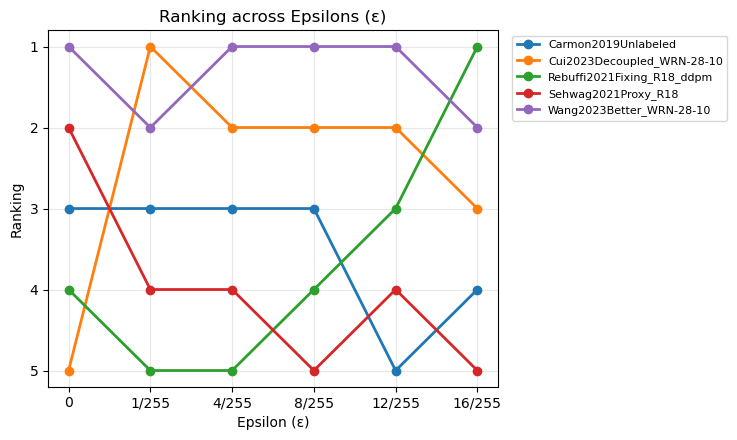

In [11]:
plot_RankingAcrossEpsilons(df)

### 4. Rank stability

In [12]:
def plot_RankStability(df):
    """
    Plot rank stability metrics for each model.
    
    This function computes two stability metrics:
    1. Rank variance: How much a model's rank varies across epsilons (higher = less stable)
    2. Max adjacent rank jump: Largest single-step rank change between consecutive epsilons
    
    Models with high values are sensitive to epsilon choice, meaning their position
    on the leaderboard is unreliable. Low values indicate consistent performance
    regardless of the perturbation budget used for evaluation.
    
    Args:
        df: DataFrame with columns 'model', 'rank'
    """
    rows = []
    # Calculate stability metrics for each model
    for model, g in df.groupby("model"):
        ranks = g["rank"].values  # Array of ranks across all epsilons
        rows.append({
            "model": model,
            "rank_var": np.var(ranks),  # Variance of ranks (spread measure)
            # Maximum absolute change between consecutive epsilon rankings
            "max_jump": np.max(np.abs(np.diff(ranks))) if len(ranks) > 1 else 0
        })

    # Create DataFrame and sort by variance (most unstable first)
    s = pd.DataFrame(rows).sort_values("rank_var", ascending=False)

    # Setup grouped bar chart
    x = np.arange(len(s))  # X positions for each model
    w = 0.4                 # Bar width

    plt.figure(figsize=(9, 4.5))
    # Plot two bars per model: variance and max jump
    plt.bar(x - w/2, s["rank_var"], width=w, label="Rank variance")
    plt.bar(x + w/2, s["max_jump"], width=w, label="Max adjacent rank jump")

    plt.xticks(x, s["model"], rotation=45, ha="right")  # Rotated model names
    plt.ylabel("Stability metric")
    plt.title("Ranking stability")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.show()

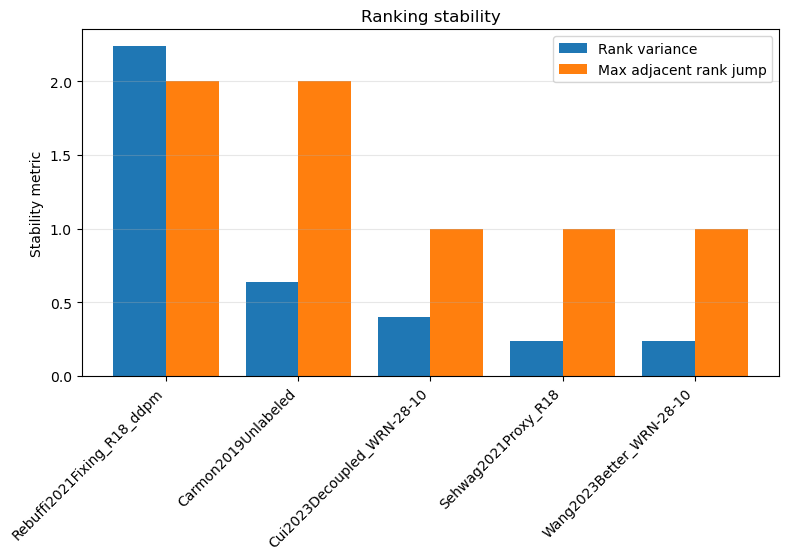

In [13]:
plot_RankStability(df)

## Tables

### 1. Robust Accuracy table

In [14]:
def showRobustAccTable(df):
    """
    Create a formatted table showing robust accuracy with accuracy drop for each model/epsilon.
    
    The table has models as rows and epsilons as columns. Each cell shows:
    - Robust accuracy as a percentage
    - Accuracy drop (clean - robust) in parentheses with a down arrow
    
    This format makes it easy to see both absolute robustness and relative degradation.
    
    Args:
        df: DataFrame with columns 'model', 'epsilon', 'clean_acc', 'robust_acc'
        
    Returns:
        pd.DataFrame: Formatted pivot table with robust accuracy and drop
    """
    
    def eps_to_float(eps_str):
        """Convert epsilon string fraction to float for sorting."""
        num, denom = eps_str.split("/")
        return int(num) / int(denom)

    # Create pivot table: rows=models, columns=epsilons, values=robust_acc
    robust_table = df.pivot_table(
        index="model",
        columns="epsilon",
        values="robust_acc",
        aggfunc="first"  # Take first value (all should be same for given model/epsilon)
    )
    # Sort columns by epsilon value (ascending)
    robust_table = robust_table[sorted(robust_table.columns, key=eps_to_float)]

    # Create similar pivot table for clean accuracy
    clean_table = df.pivot_table(
        index="model",
        columns="epsilon",
        values="clean_acc",
        aggfunc="first"
    )
    clean_table = clean_table[sorted(clean_table.columns, key=eps_to_float)]

    # Calculate accuracy drop: how much accuracy is lost under attack
    drop_table = clean_table - robust_table

    def format_with_drop(robust, drop):
        """Format cell as 'XX.XX% (↓YY.YY%)'."""
        return f"{robust:.2%} (↓{drop:.2%})"

    # Apply formatting to create final display table
    table_formatted = robust_table.copy()
    for col in robust_table.columns:
        table_formatted[col] = [
            format_with_drop(robust_table.loc[idx, col], drop_table.loc[idx, col])
            for idx in robust_table.index
        ]

    return table_formatted

In [15]:
showRobustAccTable(df)

epsilon,1/255,4/255,8/255,12/255,16/255
model,,,,,
Carmon2019Unlabeled,88.50% (↓2.00%),77.50% (↓13.00%),56.00% (↓34.50%),35.50% (↓55.00%),18.50% (↓72.00%)
Cui2023Decoupled_WRN-28-10,92.00% (↓1.50%),83.50% (↓10.00%),69.50% (↓24.00%),42.50% (↓51.00%),21.00% (↓72.50%)
Rebuffi2021Fixing_R18_ddpm,83.50% (↓2.00%),71.50% (↓14.00%),56.00% (↓29.50%),39.00% (↓46.50%),24.00% (↓61.50%)
Sehwag2021Proxy_R18,84.50% (↓2.50%),72.50% (↓14.50%),52.50% (↓34.50%),36.50% (↓50.50%),16.00% (↓71.00%)
Wang2023Better_WRN-28-10,91.50% (↓1.00%),84.00% (↓8.50%),70.00% (↓22.50%),43.50% (↓49.00%),21.00% (↓71.50%)


### 2. Rank table

In [16]:
def showRankTable(df):
    """
    Create a table showing model rankings at each epsilon value.
    
    This table directly addresses the project's main question: how stable are
    RobustBench rankings across different epsilon values? Changes in rankings
    reveal which models' relative performance depends on the evaluation setting.
    
    Rank 1 = best (highest robust accuracy), Rank N = worst for N models.
    
    Args:
        df: DataFrame with columns 'model', 'epsilon', 'rank'
        
    Returns:
        pd.DataFrame: Pivot table with ranks (integers) for each model/epsilon
    """
    
    def eps_to_float(eps_str):
        """Convert epsilon string fraction to float for sorting."""
        num, denom = eps_str.split("/")
        return int(num) / int(denom)

    # Create pivot table: rows=models, columns=epsilons, values=rank
    rank_table = df.pivot_table(
        index="model",
        columns="epsilon",
        values="rank",
        aggfunc="first"
    )
    # Sort columns by epsilon value (ascending)
    rank_table = rank_table[sorted(rank_table.columns, key=eps_to_float)]

    # Convert to integer for cleaner display (ranks are whole numbers)
    rank_table = rank_table.astype(int)

    return rank_table

In [17]:
showRankTable(df)

epsilon,1/255,4/255,8/255,12/255,16/255
model,,,,,
Carmon2019Unlabeled,3,3,3,5,4
Cui2023Decoupled_WRN-28-10,1,2,2,2,3
Rebuffi2021Fixing_R18_ddpm,5,5,4,3,1
Sehwag2021Proxy_R18,4,4,5,4,5
Wang2023Better_WRN-28-10,2,1,1,1,2
